In [1]:
from gsheets import Sheets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Setup
## Load results from google form

In [2]:
sheets = Sheets.from_files('credentials.json', 'storage.json')
s = sheets['1yEVPpnBSQhFcSIDBnlINc1V2i7Dm2knqazyD78mEaJ0']
raw = s.find('Form Responses 1').to_frame(index_col='Timestamp')
raw = raw.iloc[:, :-1]

## Rename columns and code responses

In [3]:
cols = [
    'current_run', 'current_walk', 'current_bike', 'current_swim','desired_run','desired_walk','desired_bike','desired_swim','most_trouble', 'distance_run','units_run','challenge_run','distance_walk','units_walk','challenge_walk','distance_bike','units_bike','challenge_bike','distance_swim','units_swim','challenge_swim'
]

code_mapping = {
    'Never': 0,
    'Less than once a month': 1,
    '1-3 times a month': 2,
    'Once a week': 3,
    'More than once a week': 4,
    'Running / jogging': 'run',
    'Walking': 'walk',
    'Cycling / biking': 'bike',
    'Swimming': 'swim',
    'Kilometers': 'km',
    'Never': 0,
    'Less than one week per month': 1,
    'About one week per month': 2,
    'More than one week per month': 3,
    'Every week': 4
}

## Prepare dataset

In [4]:
df = raw
df.columns = cols
df = df.replace(code_mapping)
df['respondent'] = pd.factorize(df.index, sort=True)[0] + 1
df = df.set_index('respondent')
df['units'] = df.units_walk.fillna('') + df.units_run.fillna('') + df.units_swim.fillna('') + df.units_bike.fillna('')
df['challenge'] = df.challenge_walk.fillna(0) + df.challenge_run.fillna(0) + df.challenge_swim.fillna(0) + df.challenge_bike.fillna(0)
df['distance'] = df.distance_walk.fillna(0) + df.distance_run.fillna(0) + df.distance_swim.fillna(0) + df.distance_bike.fillna(0) 
df = df.drop(columns = ['units_walk', 'units_run', 'units_swim', 'units_bike',
                        'challenge_walk', 'challenge_run', 'challenge_swim', 'challenge_bike',
                        'distance_walk', 'distance_run', 'distance_swim', 'distance_bike'])
# convert distances to km
df.loc[df['units'] == 'km', 'distance_km'] = df.distance
df.loc[df['units'] == 'Miles', 'distance_km'] = df.distance * 1.60934
# compute deltas between desired and actual frequency per activity
df['delta_run'] = df.desired_run - df.current_run
df['delta_walk'] = df.desired_walk - df.current_walk
df['delta_swim'] = df.desired_swim - df.current_swim
df['delta_bike'] = df.desired_bike - df.current_bike

# save df to disc
df.to_csv('exercsie_survey_data.csv')

df.head()

,current_run,current_walk,current_bike,current_swim,desired_run,desired_walk,desired_bike,desired_swim,most_trouble,units,challenge,distance,distance_km,delta_run,delta_walk,delta_swim,delta_bike
respondent,,,,,,,,,,,,,,,,,
1,4,4,1,1,4,4,3,2,bike,km,2.0,10.0,10.000,0,0,1,2
2,1,3,0,0,3,4,1,3,bike,km,0.0,15.0,15.000,2,1,3,1
10,1,4,0,4,0,4,4,4,bike,km,4.0,20.0,20.000,-1,0,0,4
13,0,0,4,0,0,0,4,0,bike,Miles,4.0,200.0,321.868,0,0,0,0
14,4,4,0,0,4,4,3,4,swim,km,0.0,5.0,5.000,0,0,4,3


# Analysis

## Research Question 0: How often do people do each exercise type? Number of respondents

In [27]:
melted = pd.melt(df.filter(like = 'current', axis = 1))
melted = melted.groupby(['variable', 'value']).size().to_frame('size').reset_index()
# melted['prop'] = melted['size'] / len(df)
current = melted.pivot(index = 'variable', columns = 'value', values = 'size').fillna(0)
current.columns =     ['Never', 'Less than once a month', '1-3 times a month', 'Once a week','More than once a week']
current['|'] = '|'
current['At least once a month'] = current['1-3 times a month'] + current['Once a week'] + current['More than once a week']
print('Total respondents:', len(df))
current

Total respondents: 44


,Never,Less than once a month,1-3 times a month,Once a week,More than once a week,|,At least once a month
variable,,,,,,,
current_bike,17.0,7.0,4.0,8.0,8.0,|,20.0
current_run,15.0,8.0,6.0,5.0,10.0,|,21.0
current_swim,26.0,11.0,2.0,1.0,4.0,|,7.0
current_walk,4.0,0.0,0.0,9.0,31.0,|,40.0


## Research Question 1: For which type of exercise are people least satisfied with their level of activity?

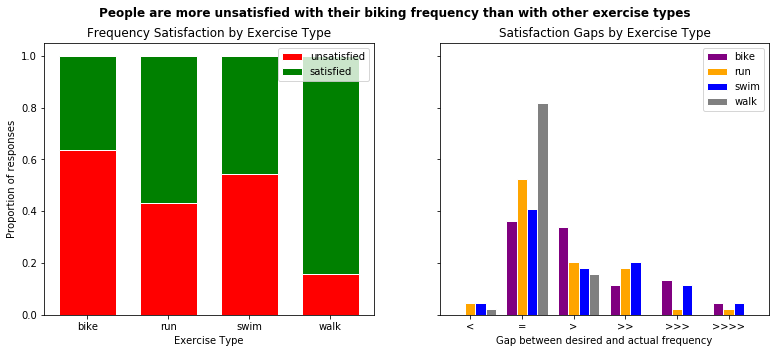

In [5]:
melted = pd.melt(df.filter(like = 'delta', axis = 1))
melted = melted.groupby(['variable', 'value']).size().to_frame('size').reset_index()
melted['prop'] = melted['size'] / len(df)
deltas = melted.pivot(index = 'value', columns = 'variable', values = 'prop').fillna(0)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex = False, sharey = True, figsize = (13, 5))

fig.suptitle('People are more unsatisfied with their biking frequency than with other exercise types', fontweight = 'bold')

# satisfaction
satisfied = deltas.iloc[0:2].sum()
unsatisfied = deltas.iloc[2:6].sum()

barWidth = 0.7
names = ('bike','run','swim','walk')
ax1.bar(names, unsatisfied, color='red', edgecolor='white', width=barWidth, label = 'unsatisfied')
# Create orange Bars
ax1.bar(names, satisfied, bottom=unsatisfied, color='green', edgecolor='white', width=barWidth, label = 'satisfied')


ax1.set(xlabel= "Exercise Type", 
        ylabel = "Proportion of responses",
        title = 'Frequency Satisfaction by Exercise Type')

ax1.legend()

# gap detail
barWidth = 0.2

bike = deltas.delta_bike
swim = deltas.delta_swim
run = deltas.delta_run 
walk = deltas.delta_walk

r1 = np.arange(len(bike))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

ax2.bar(r1, bike, color='purple', width=barWidth, edgecolor='white', label='bike')
ax2.bar(r2, run, color='orange', width=barWidth, edgecolor='white', label='run')
ax2.bar(r3, swim, color='blue', width=barWidth, edgecolor='white', label='swim')
ax2.bar(r4, walk, color='grey', width=barWidth, edgecolor='white', label='walk')

ax2.set(xlabel= "Gap between desired and actual frequency", 
        title = 'Satisfaction Gaps by Exercise Type')
plt.xticks([r + barWidth for r in range(len(bike))], ['<', '=', '>', '>>', '>>>', '>>>>'])

ax2.legend();

## Research Question 2: Which type of exercise do people say they have the most trouble doing as much as they'd like?

In [6]:
trouble = df.filter(items = ['most_trouble', 'units'])

trouble_total = trouble.groupby('most_trouble').size().to_frame('size').reset_index()
trouble_total['prop'] = trouble_total['size'] / len(df)

trouble_units = trouble.groupby(['units', 'most_trouble']).size().to_frame('size').reset_index()
trouble_units['prop'] = trouble_units['size'] / len(df)

''

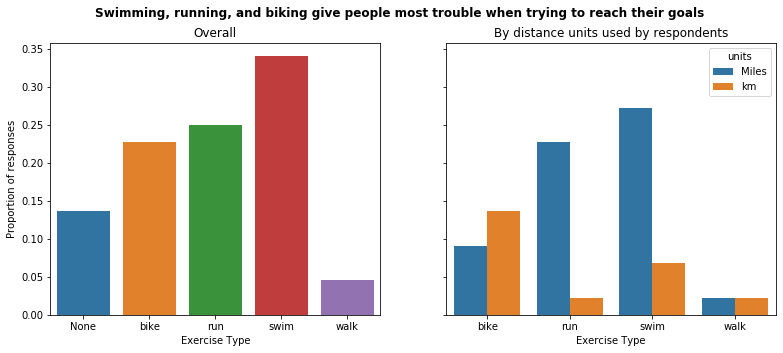

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex = False, sharey = True, figsize = (13, 5))
fig.suptitle('Swimming, running, and biking give people most trouble when trying to reach their goals ', fontweight = 'bold')
sns.barplot(x="most_trouble", y="prop", data=trouble_total, ax = ax1)
ax1.set(title = 'Overall',
       xlabel = 'Exercise Type',
       ylabel = 'Proportion of responses')

sns.barplot(x='most_trouble', y='prop', hue = 'units', data = trouble_units.iloc[1:], ax = ax2)
ax2.set(title = 'By distance units used by respondents',
        xlabel = 'Exercise Type',
        ylabel = '')
;

## Research Question 3: How often do people have trouble completing their most challenging exercise type?

In [8]:
codes = {0: '4: never', 1: '3: <1 week / month', 2: '2: ~1 week / month', 3: '1: >1 week / month', 4: '0: every week'}
chall = df.filter(items = ['most_trouble', 'challenge']).replace(codes)
chall_tab = pd.crosstab(chall['most_trouble'], chall['challenge'], normalize='index').iloc[1:]
chall_tab.columns = ['every week', '>1 week / month', '~1 week / month', '<1 week / month', 'never']

''

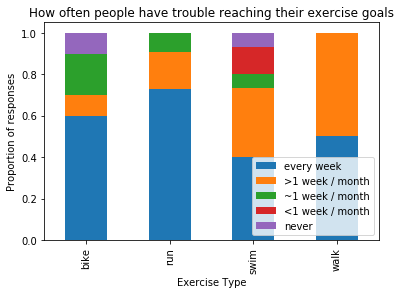

In [9]:
ax = chall_tab.plot.bar(stacked = True)
ax.set(title = 'How often people have trouble reaching their exercise goals',
       xlabel = 'Exercise Type',
       ylabel = 'Proportion of responses')
ax.legend(loc = 'lower right')
;

## Research Question 4: How far do people want to go per week in each exercise type

''

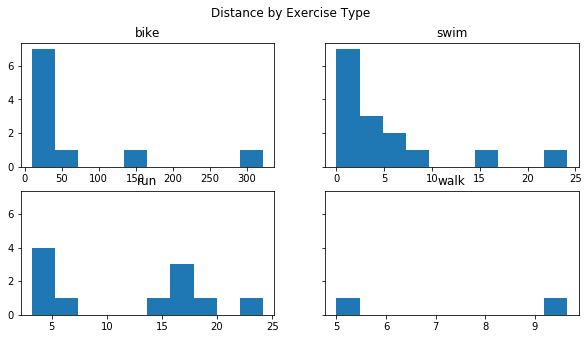

In [10]:

fig, axes = plt.subplots(nrows=2, ncols=2, sharex = False, sharey = True, figsize = (10, 5))
axes = axes.flatten()

plt.suptitle('Distance by Exercise Type')


types = df.most_trouble.unique()
types = types[types != 'None']
ax = 0
for i in types:
    data = df.loc[df['most_trouble'] == i]
    plt.sca(axes[ax])
    plt.hist(data.distance_km)
    plt.title(i)
    ax = ax + 1

;


In [11]:
df.most_trouble.unique()

array(['bike', 'swim', 'None', 'run', 'walk'], dtype=object)